In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.lib import distances 
from MDAnalysis.analysis import rdf
import MDAnalysisData as data

from modules.sw_directories import *
import os
import re
import numpy as np

/home/dan/miniconda3/envs/AmberTools23/lib/python3.12/site-packages/MDAnalysisData/base.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string


In [2]:
dirs = PolymerSimulatorDirs(os.getcwd())

In [3]:
system_name = "3HB_4_polymer_single_chain_23"
top, anneal_files, equili_files, prod_files = dirs.retrieve_files_for_MDanalysis(system_name)

3HB_4_polymer_single_chain_23
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957
/home/dan/polymersimulator/pdb_files/sys

In [89]:
class Analysis():
    # These are some base methods that will be used by specific analysis classes
    def __init__(self):
        pass

    @staticmethod
    def extract_filename(filepath):
            # Extract the filename from the full path
            filename_with_extension = filepath.split('/')[-1]
    
            # Remove the date and time (pattern: YYYY-MM-DD_HHMMSS)
            filename_without_date = re.sub(r'_\d{4}-\d{2}-\d{2}_\d{6}', '', filename_with_extension)
    
            # Remove the file extension
            filename_without_extension = filename_without_date.split('.')[0]
    
            return(filename_without_extension)
    
    @staticmethod
    def plot_ROG(universe, atom_group, atom_group_name, graph_filepath=None, traj_filename=None):
        # universe = mdanalysis univers
        # atom_group = mdanalysis atom group
        # atom_group_name = str of atom_group_identifier (i.e. "_polymer", "_polymer_backbone", ect..)

        rog = []

        for ts in universe.trajectory:
            rog.append(atom_group.radius_of_gyration())

        plt.plot(rog)
        plt.xlabel('frame')
        plt.ylabel(r"R$_{g}$ ($\AA$)")
        if graph_filepath == None or traj_filename == None:
            # Default path is just used generally and not part of another analysis
            graph_filepath = os.path.join(os.getcwd(), "ROG_graph")
            print(graph_filepath)
        else:
            graph_filepath = os.path.join(graph_filepath, traj_filename + atom_group_name + "_ROG_graph")
        plt.savefig(graph_filepath)
        avg_rog = sum(rog) / len(rog)
        return(avg_rog)

    @staticmethod
    def plot_COG(universe, atom_group, atom_group_name, graph_filepath=None, traj_filename=None):
        # universe = mdanalysis univers
        # atom_group = mdanalysis atom group
        # atom_group_name = str of atom_group_identifier (i.e. "_polymer", "_polymer_backbone", ect..)

        cog = []

        for ts in universe.trajectory:
            cog.append(atom_group.center_of_mass())

        cog = np.array(cog)
    
        # Now let's plot each coordinate separately
        plt.plot(cog[:, 0], label='x')
        plt.plot(cog[:, 1], label='y')
        plt.plot(cog[:, 2], label='z')

        # Add labels and legend
        plt.xlabel('Frame')
        plt.ylabel(r"R$_{g}$ ($\AA$)")
        plt.legend()
        if graph_filepath == None or traj_filename == None:
            # Default path is just used generally and not part of another analysis
            graph_filepath = os.path.join(os.getcwd(), "COG_graph")
            print(graph_filepath)
        else:
            graph_filepath = os.path.join(graph_filepath, traj_filename + atom_group_name + "_COG_graph")
        plt.savefig(graph_filepath)
        avg_x_cog = sum(cog[:,0])/len(cog[:,0])
        avg_y_cog = sum(cog[:,1])/len(cog[:,1])
        avg_z_cog = sum(cog[:,2])/len(cog[:,2])
        return(avg_x_cog, avg_y_cog, avg_z_cog)

          
class SinglePolyAnalysis(Analysis):
    # This class is for static methods for a specific analysis
    def __init__(self):
        self.log_info = {'Production': {'ROG': None, 'COG_x': None, 'COG_y': None, 'COG_z': None}}

    @staticmethod
    def select_polymer(universe):
        polymer_atom_group = universe.select_atoms('not resname WAT')
        return(polymer_atom_group)
        
    @staticmethod
    def select_polymer_backbone(polymer_atom_group):
        # Ensure a polymer atom group is passed to this function!
        def check_h_count(data):
            # Embedded function - normally would define this outside, but it is specific here
            h_count = 0
            for _, atom_array in bonded_atoms_info:
                for atom in atom_array:
                    if 'h' in atom:
                        h_count = h_count + 1
            return(h_count)
 
        carbons = polymer_atom_group.select_atoms('type c or type c3')
        backbone_carbons_idx = []
        for atom in carbons:
            bonded_atoms_indices = atom.bonds.to_indices()
            bonded_atoms = [polymer_atom_group.atoms[idx] for idx in bonded_atoms_indices]
            bonded_atoms_info = [(bonded_atom.indices, bonded_atom.types) for bonded_atom in bonded_atoms]
            #print(f"Atom {atom.index} ({atom.type}) is bonded to:")
            for idx, symbol in bonded_atoms_info:
                #print(f"  - Atom {idx} ({symbol}) ")
                pass
            if check_h_count(bonded_atoms_info) >= 3:
                pass
            else:
                backbone_carbons_idx.append(atom.index)
        select_string = ""
        for i in range(len(backbone_carbons_idx)):
            if i == 0:
                select_string = select_string + "index " + str(backbone_carbons_idx[i])
            else:
                select_string = select_string + " or index " + str(backbone_carbons_idx[i])
        select_string = select_string + " or type os"
        backbone = polymer_atom_group.select_atoms(select_string)
        return(backbone)

    def update_rog_val(self, rog_value):
        # Update average ROG value in our class
        self.log_info['Production']['ROG'] = rog_value

    def update_cog_vals(self, cog_x, cog_y, cog_z):
        self.log_info['Production']['COG_x'] = cog_x
        self.log_info['Production']['COG_y'] = cog_y
        self.log_info['Production']['COG_z'] = cog_z

    

class Universe(Analysis):
    def __init__(self, topology_file, trajectory_file):
        
        self.topo_file = topology_file
        self.traj_file = trajectory_file
        self.universe = mda.Universe(self.topo_file, self.traj_file)
        self.output_filepath = os.path.dirname(self.traj_file)
        self.filename = self.extract_filename(self.traj_file)


In [90]:
dcd = "/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/2024-05-30_194957/3HB_4_polymer_single_chain_23_prod_traj_2024-05-30_194957.dcd"
top = "/home/dan/polymersimulator/pdb_files/systems/3HB_4_polymer_single_chain_23/3HB_4_polymer_single_chain_23.prmtop"

# Call the unverse class - we will still use the mdanalysis as intended, but we can store some specific variables for our specific analysis (i.e. output file destination)
universe = Universe(top, dcd)
u = universe.universe
u

/home/dan/miniconda3/envs/AmberTools23/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<Universe with 18516 atoms>

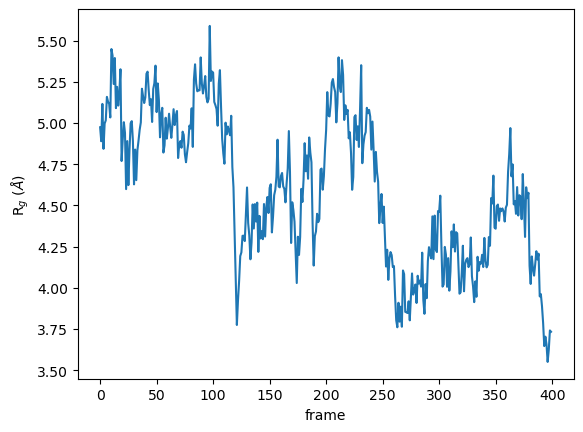

In [91]:
# Create the instance containing functions to analysis a single solvated polymer
poly_anal = SinglePolyAnalysis()

# This instance has a function to select all polymer residues
polymer_atom_group = poly_anal.select_polymer(u)

# And the polymer backbone of 
polymer_backbone = poly_anal.select_polymer_backbone(polymer_atom_group)

# Calculate radius of gyration for our polymer and save the graph
rog = poly_anal.plot_ROG(u, polymer_atom_group, "_polymer", universe.output_filepath, universe.filename)

# Update average ROG value in our class
poly_anal.update_rog_val(rog)

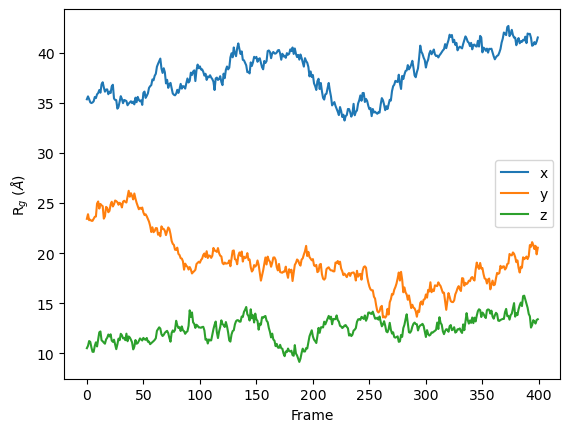

In [7]:
# Calculate centre of geometry for our polymer and save the graph
x, y, z = poly_anal.plot_COG(u, polymer_atom_group, "_polymer", universe.output_filepath, universe.filename)

# Update average centre of geometry values in our class
poly_anal.update_cog_vals(x,y,z)

In [8]:
poly_anal.log_info

{'Production': {'ROG': 4.598732391148754,
  'COG_x': 38.03269192676498,
  'COG_y': 19.128484185050446,
  'COG_z': 12.439006584102831}}

# Below is polymer backbone selection dev

In [9]:
# add a universe (or atomgroup)
view = nv.show_mdanalysis(polymer_atom_group)

# launch the viewer
view

NGLWidget(max_frame=399)

In [68]:
# Print out the atom types
#for atom in polymer_atom_group:
   # print(atom.type)

In [92]:
backbone = polymer_atom_group.select_atoms("type c or type c3 or type os")

# add a universe (or atomgroup)
view = nv.show_mdanalysis(polymer_backbone)

# launch the viewer
view

NGLWidget(max_frame=399)

In [70]:
carbons = polymer_atom_group.select_atoms("type c or type c3")
# add a universe (or atomgroup)
view = nv.show_mdanalysis(carbons)

# launch the viewer
view

NGLWidget(max_frame=399)

In [85]:




# Function to check if 'h' appears 3 times or more in the second array
def check_h_count(data):
    h_count = 0
    for _, atom_array in bonded_atoms_info:
        for atom in atom_array:
            if 'h' in atom:
                h_count = h_count + 1
    return(h_count)

       

#

backbone_carbons_idx = []
for atom in carbons:
    bonded_atoms_indices = atom.bonds.to_indices()
    bonded_atoms = [polymer_atom_group.atoms[idx] for idx in bonded_atoms_indices]
    bonded_atoms_info = [(bonded_atom.indices, bonded_atom.types) for bonded_atom in bonded_atoms]
    print(f"Atom {atom.index} ({atom.type}) is bonded to:")
    for idx, symbol in bonded_atoms_info:
        print(f"  - Atom {idx} ({symbol}) ")
    if check_h_count(bonded_atoms_info) >= 3:
        pass
    else:
        backbone_carbons_idx.append(atom.index)



Atom 0 (c3) is bonded to:
  - Atom [0 1] (['c3' 'hc']) 
  - Atom [0 2] (['c3' 'hc']) 
  - Atom [0 3] (['c3' 'c']) 
Atom 3 (c) is bonded to:
  - Atom [0 3] (['c3' 'c']) 
  - Atom [3 4] (['c' 'o']) 
  - Atom [3 5] (['c' 'oh']) 
  - Atom [3 7] (['c' 'c3']) 
Atom 7 (c3) is bonded to:
  - Atom [3 7] (['c' 'c3']) 
  - Atom [7 8] (['c3' 'h1']) 
  - Atom [7 9] (['c3' 'c3']) 
  - Atom [ 7 13] (['c3' 'os']) 
Atom 9 (c3) is bonded to:
  - Atom [7 9] (['c3' 'c3']) 
  - Atom [ 9 10] (['c3' 'hc']) 
  - Atom [ 9 11] (['c3' 'hc']) 
  - Atom [ 9 12] (['c3' 'hc']) 
Atom 14 (c3) is bonded to:
  - Atom [13 14] (['os' 'c3']) 
  - Atom [14 15] (['c3' 'hc']) 
  - Atom [14 16] (['c3' 'hc']) 
  - Atom [14 17] (['c3' 'c']) 
Atom 17 (c) is bonded to:
  - Atom [14 17] (['c3' 'c']) 
  - Atom [17 18] (['c' 'o']) 
  - Atom [17 19] (['c' 'c3']) 
Atom 19 (c3) is bonded to:
  - Atom [17 19] (['c' 'c3']) 
  - Atom [19 20] (['c3' 'c3']) 
  - Atom [19 24] (['c3' 'h1']) 
  - Atom [19 25] (['c3' 'os']) 
Atom 20 (c3) is bond

Attempt at only selecting the backbone

In [78]:
backbone_carbons_idx

[0, 3, 7, 14, 17, 19, 26, 29, 31, 38, 40, 43]

In [79]:
select_string = ""
for i in range(len(backbone_carbons_idx)):
    if i == 0:
        select_string = select_string + "index " + str(backbone_carbons_idx[i])
    else:
        select_string = select_string + " or index " + str(backbone_carbons_idx[i])
select_string = select_string + " or type os"

In [80]:
select_string

'index 0 or index 3 or index 7 or index 14 or index 17 or index 19 or index 26 or index 29 or index 31 or index 38 or index 40 or index 43 or type os'

In [86]:
backbone = select_polymer_backbone(polymer_atom_group)

# add a universe (or atomgroup)
view = nv.show_mdanalysis(backbone)

# launch the viewer
view

Atom 0 (c3) is bonded to:
  - Atom [0 1] (['c3' 'hc']) 
  - Atom [0 2] (['c3' 'hc']) 
  - Atom [0 3] (['c3' 'c']) 
Atom 3 (c) is bonded to:
  - Atom [0 3] (['c3' 'c']) 
  - Atom [3 4] (['c' 'o']) 
  - Atom [3 5] (['c' 'oh']) 
  - Atom [3 7] (['c' 'c3']) 
Atom 7 (c3) is bonded to:
  - Atom [3 7] (['c' 'c3']) 
  - Atom [7 8] (['c3' 'h1']) 
  - Atom [7 9] (['c3' 'c3']) 
  - Atom [ 7 13] (['c3' 'os']) 
Atom 9 (c3) is bonded to:
  - Atom [7 9] (['c3' 'c3']) 
  - Atom [ 9 10] (['c3' 'hc']) 
  - Atom [ 9 11] (['c3' 'hc']) 
  - Atom [ 9 12] (['c3' 'hc']) 
Atom 14 (c3) is bonded to:
  - Atom [13 14] (['os' 'c3']) 
  - Atom [14 15] (['c3' 'hc']) 
  - Atom [14 16] (['c3' 'hc']) 
  - Atom [14 17] (['c3' 'c']) 
Atom 17 (c) is bonded to:
  - Atom [14 17] (['c3' 'c']) 
  - Atom [17 18] (['c' 'o']) 
  - Atom [17 19] (['c' 'c3']) 
Atom 19 (c3) is bonded to:
  - Atom [17 19] (['c' 'c3']) 
  - Atom [19 20] (['c3' 'c3']) 
  - Atom [19 24] (['c3' 'h1']) 
  - Atom [19 25] (['c3' 'os']) 
Atom 20 (c3) is bond

NGLWidget(max_frame=399)

In [12]:
# Select all carbon atoms
carbon_atoms = polymer_atom_group.select_atoms('type c or type c3')

# Select all hydrogen atoms
hydrogen_atoms = polymer_atom_group.select_atoms('type ho or type hc or type h1')

In [13]:
a = (carbon_atoms[1]).index
b = (carbon_atoms[2]).index
c = a + b
c

10

In [24]:
# Create a list to store carbons not bonded to exactly three hydrogens
carbons_not_bonded_to_three_hydrogens = []

# Iterate over each carbon atom to count bonded hydrogens
for carbon in carbon_atoms:
    #print(carbon)
    # Find all hydrogens within a bond length (typically ~1.1 Å)
    bonded_hydrogens = hydrogen_atoms.select_atoms(f'around 1.5 index {carbon.index}')
    print("BONDED H", bonded_hydrogens)
    # Check if the number of bonded hydrogens is not three
    if len(bonded_hydrogens) != 3:
        carbons_not_bonded_to_three_hydrogens.append(carbon)

# Convert the list to an AtomGroup
#carbons_not_bonded_to_three_hydrogens = mda.core.groups.AtomGroup(carbons_not_bonded_to_three_hydrogens, u)

# Print the selection
index_to_select = []
#print(carbons_not_bonded_to_three_hydrogens)
for i in range(len(carbons_not_bonded_to_three_hydrogens)):
   index_to_select.append(carbons_not_bonded_to_three_hydrogens[i].index)



BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>
BONDED H <AtomGroup []>


In [25]:
index_to_select

[0, 3, 7, 9, 14, 17, 19, 20, 26, 29, 31, 32, 38, 40, 43, 44]

In [26]:
select_string = ""
for i in range(len(index_to_select)):
    if i == 0:
        select_string = select_string + "index " + str(index_to_select[i])
    else:
        select_string = select_string + " or index " + str(index_to_select[i])
select_string = select_string + " or type os"

In [27]:
backbone = polymer_atom_group.select_atoms(select_string)

# add a universe (or atomgroup)
view = nv.show_mdanalysis(backbone)

# launch the viewer
view

NGLWidget(max_frame=399)

In [30]:
# add a universe (or atomgroup)
view = nv.show_mdanalysis(carbons_not_bonded_to_three_hydrogens)

# launch the viewer
view

AttributeError: 'list' object has no attribute 'universe'